In [1]:
!pip install xarray prophet gluonts mxnet h5py mxnet-mkl==1.6.0 numpy==1.23.1

  Obtaining dependency information for xarray from https://files.pythonhosted.org/packages/c3/0a/56eadeb54f258e88f2f31e79fcb84079f8757298f4257d716cbbc674c460/xarray-2023.11.0-py3-none-any.whl.metadata
  Using cached xarray-2023.11.0-py3-none-any.whl.metadata (11 kB)
  Obtaining dependency information for prophet from https://files.pythonhosted.org/packages/6b/3c/79d6da1af2a9bd6a534c5a283271eff1bdd673241cda795919a2b41578b3/prophet-1.1.5-py3-none-macosx_10_9_x86_64.whl.metadata
  Using cached prophet-1.1.5-py3-none-macosx_10_9_x86_64.whl.metadata (3.5 kB)
  Obtaining dependency information for gluonts from https://files.pythonhosted.org/packages/20/3d/30ff04c7640094b00c9a79cc4d4d62c40deb43fed49e1a5b162c39a3d229/gluonts-0.14.1-py3-none-any.whl.metadata
  Using cached gluonts-0.14.1-py3-none-any.whl.metadata (9.5 kB)
  Using cached mxnet-1.9.1-py3-none-macosx_10_13_x86_64.whl (39.5 MB)
  Obtaining dependency information for h5py from https://files.pythonhosted.org/packages/27/6b/c5ce9d753f

In [2]:
pip install cpflows

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 562.4 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for backports.functools-lru-cache>=1.6.1 from https://files.pythonhosted.org/packages/08/e3/1387bd1c9aa95e354064ee29b8a1dfd3e795b066cc869af8f8d6b70ae4aa/backports.functools_lru_cache-1.6.6-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 kB 462.2 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 1.5 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for cpflows: filename=cpflows-0.1.2-py3-none-any.whl size=54299 sha256=cb2658e

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3.9 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


ImportError: cannot import name 'MQF2Estimator' from 'gluonts.model' (/usr/local/lib/python3.9/site-packages/gluonts/model/__init__.py)

In [23]:
import xarray as xr
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from prophet import Prophet
from matplotlib.dates import date2num

from gluonts.torch.model.mqf2 import MQF2MultiHorizonEstimator
from gluonts.mx.distribution import ZeroInflatedNegativeBinomialOutput, StudentTOutput #likelihood
from gluonts.mx.trainer.learning_rate_scheduler import LearningRateReduction
from gluonts.mx.trainer import Trainer
from gluonts.mx.trainer.model_averaging import ModelAveraging, SelectNBestSoftmax, SelectNBestMean

from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas

latitudes = np.flipud(np.arange(65) * 0.25 + 5)
longitudes = np.arange(37) * 0.25 + 97

In [4]:
ds = xr.open_dataset("data/temp2m.nc")
df = ds.to_dataframe()
df.reset_index(inplace=True)
df['date'] = df['date'].dt.date
df['lat'] = [latitudes[i] for i in df['lat']]
df['lon'] = [longitudes[i] for i in df['lon']]
df['lat_lon'] = df['lat'].astype(str) + ', ' + df['lon'].astype(str)
df = df.groupby(['date', 'lat_lon'])['temp2m'].max().reset_index()
pivoted_df = df.pivot(index=['date'], columns='lat_lon', values='temp2m').reset_index()
pivoted_df = pivoted_df.set_index('date')
pivoted_df

lat_lon,"10.0, 100.0","10.0, 100.25","10.0, 100.5","10.0, 100.75","10.0, 101.0","10.0, 101.25","10.0, 101.5","10.0, 101.75","10.0, 102.0","10.0, 102.25",...,"9.75, 97.5","9.75, 97.75","9.75, 98.0","9.75, 98.25","9.75, 98.5","9.75, 98.75","9.75, 99.0","9.75, 99.25","9.75, 99.5","9.75, 99.75"
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,28.162183,28.162183,28.262183,28.362183,28.462183,28.462183,28.562183,28.562183,28.662183,28.662183,...,27.962183,27.962183,28.062183,27.962183,31.562183,31.662183,31.162183,27.862183,27.962183,27.962183
2020-01-02,28.121875,28.121875,28.221875,28.221875,28.221875,28.321875,28.521875,29.021875,29.121875,29.121875,...,27.721875,27.821875,27.821875,28.021875,31.521875,31.721875,31.021875,27.821875,27.821875,27.913818
2020-01-03,28.470313,28.670313,28.770313,28.770313,28.770313,28.770313,28.770313,28.770313,28.670313,28.670313,...,27.895728,27.795728,27.870313,28.170313,31.670313,31.370313,30.870313,28.070313,27.970313,27.970313
2020-01-04,28.396338,28.396338,28.448950,28.496338,28.496338,28.596338,28.596338,28.596338,28.548950,28.596338,...,28.048950,28.096338,28.096338,28.196338,31.996338,32.396338,31.596338,28.148950,28.196338,28.248950
2020-01-05,28.538770,28.638770,28.638770,28.638770,28.638770,28.638770,28.738770,28.938770,28.938770,28.938770,...,28.050024,27.950024,28.038770,28.138770,32.338770,32.138770,31.438770,28.238770,28.338770,28.338770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-17,28.529922,28.759922,28.909922,28.949922,28.939922,28.919922,28.829922,28.679922,28.569922,28.569922,...,28.467754,28.303398,28.143398,28.013398,27.809922,25.489922,26.829922,27.869922,27.859922,27.959922
2023-11-18,27.884727,27.914727,28.007402,28.297402,28.707402,28.877402,28.767402,28.537402,28.207402,28.101074,...,28.131074,28.031074,27.801074,27.474727,26.744727,24.024727,25.644727,27.538940,27.764727,27.804727
2023-11-19,27.587480,27.646133,28.076133,27.996133,27.986133,27.977480,28.001367,27.976133,27.877480,27.957480,...,27.746133,27.976133,28.376133,28.826133,29.356133,27.426133,27.586133,28.016133,27.926133,27.936133


In [5]:
training_list = []
for data in pivoted_df:
    training_list.append({"start": pivoted_df.index[0], "target": pivoted_df[data][:datetime.date(2023, 1, 1)].tolist()})

In [6]:
training_data = ListDataset(
    training_list,
    freq="D"
)

In [7]:
entry = next(iter(training_data))
train_series = to_pandas(entry)

In [8]:
test_list = []
for data in pivoted_df:
    test_list.append({"start": pivoted_df.index[0], "target": pivoted_df[data][:datetime.date(2023, 11, 19)].tolist()})

In [9]:
test_data = ListDataset(
    test_list,
    freq="D"
)

In [10]:
entry = next(iter(test_data))
test_series = to_pandas(entry)

In [11]:
index_train_end = pivoted_df.index.get_loc(datetime.date(2023, 1, 1))

In [12]:
index_train_end

1096

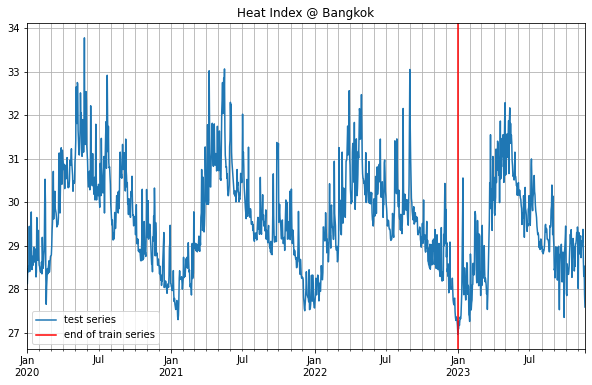

In [13]:
plt.figure(figsize=(10, 6))
test_series.plot(title='Heat Index @ Bangkok')

plt.axvline(pivoted_df.index[index_train_end], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="lower left")
plt.show()

## Select the Model

In [37]:

# MQF2MultiHorizonEstimator configuration
estimator = MQF2MultiHorizonEstimator(
    freq="1D",
    prediction_length=306,
)

# Trainer configuration (replace with your preferences)
trainer = Trainer(
    epochs=10,
    # ... other trainer parameters
)

# Training the model
predictor = estimator.train(training_data=training_data, trainer=trainer)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


TypeError: __init__() got an unexpected keyword argument 'serialized_options'

In [44]:
# forecast_it, ts_it = make_evaluation_predictions(
#     dataset=test_data,  # test dataset
#     predictor=predictor,  # predictor
#     num_samples=100,  # number of sample paths we want for evaluation
# )

In [61]:
import random

In [62]:
test_data2 = ListDataset(
    random.sample(test_list, 20),
    freq="D"
)

In [63]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data2,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [64]:
forecasts = list(forecast_it)
tss = list(ts_it)
ts_entry = tss[0]
forecast_entry = forecasts[0]

In [49]:
forecast_entry

gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=array([[37.041847, 36.707542, 35.07993 , ..., 27.695225, 28.34792 ,
        30.082323],
       [38.874443, 40.151157, 39.82454 , ..., 24.170599, 27.03646 ,
        30.780495],
       [37.37975 , 37.628155, 34.846016, ..., 25.828947, 23.447027,
        21.572893],
       ...,
       [32.952843, 36.450836, 36.675232, ..., 26.41799 , 27.037415,
        30.12616 ],
       [34.74353 , 36.090004, 36.35388 , ..., 29.662699, 30.268085,
        28.187391],
       [37.12112 , 35.285973, 33.944523, ..., 23.684633, 25.380077,
        25.562332]], dtype=float32), start_date=Period('2023-01-18', 'D'))

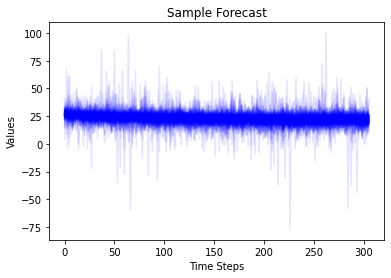

In [65]:


# Plotting
num_samples = forecast_entry.samples.shape[0]
num_steps = forecast_entry.samples.shape[1]

for i in range(num_samples):
    plt.plot(range(num_steps), forecast_entry.samples[i], color='blue', alpha=0.1)

plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.title('Sample Forecast')
plt.show()

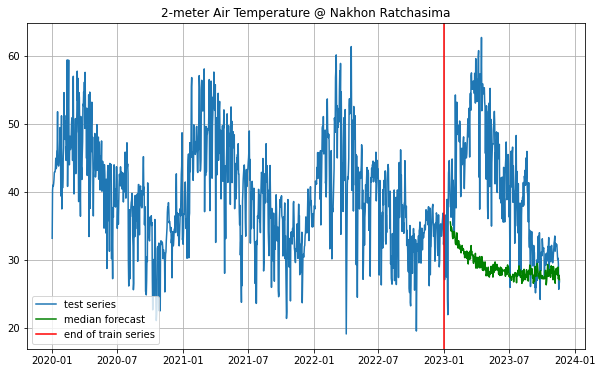

In [66]:
index = 5
plt.figure(figsize=(10, 6))
plt.plot(tss[index].to_timestamp(),label="test series")


# Assuming forecasts[index] is a gluonts.model.forecast.Forecast object
forecast_index = np.array(forecasts[index].index.to_timestamp())
forecast_values = np.array(forecasts[index].quantile(0.5))  # Convert to numpy array

plt.plot(forecast_index, forecast_values, label="median forecast", color='g')


plt.grid(which="both")
plt.axvline(pivoted_df.index[index_train_end], color='r', label="end of train series") # end of train dataset
plt.legend(loc="lower left")
plt.title('2-meter Air Temperature @ Nakhon Ratchasima')


plt.show()

In [ ]:
index = 131
plt.figure(figsize=(10, 6))
plt.plot(tss[index].to_timestamp(),label="test series")


# Assuming forecasts[index] is a gluonts.model.forecast.Forecast object
forecast_index = np.array(forecasts[index].index.to_timestamp())
forecast_values = np.array(forecasts[index].quantile(0.5))  # Convert to numpy array

plt.plot(forecast_index, forecast_values, label="median forecast", color='g')


plt.grid(which="both")
plt.axvline(pivoted_df.index[index_train_end], color='r', label="end of train series") # end of train dataset
plt.legend(loc="lower left")
plt.title('2-meter Air Temperature @ Nakhon Ratchasima')


plt.show()

In [66]:
!pip list

Package                       Version
----------------------------- -----------
alabaster                     0.7.13
anaconda-client               1.11.2
anaconda-navigator            2.4.0
anaconda-project              0.11.1
annotated-types               0.6.0
ansi2html                     1.8.0
appdirs                       1.4.4
APScheduler                   3.10.4
attrs                         22.1.0
Babel                         2.13.1
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
beautifulsoup4                4.12.2
bleach                        6.0.0
blinker                       1.6.2
bokeh                         3.1.1
boltons                       23.0.0
boto3                         1.28.58
botocore                      1.31.58
Bottleneck                    1.3.5
brotlipy                      0.7.0
Cartopy                       0.21.1
certifi                       2023.5.7
cffi                          1.15.1
c

In [40]:
!pip list

Package                              Version
------------------------------------ --------------------
alabaster                            0.7.12
anaconda-client                      1.11.0
anaconda-project                     0.11.1
annotated-types                      0.6.0
anyio                                3.5.0
appdirs                              1.4.4
argon2-cffi                          21.3.0
argon2-cffi-bindings                 21.2.0
arrow                                1.2.2
astroid                              3.0.0
astropy                              5.3.4
asttokens                            2.4.0
atomicwrites                         1.4.0
attrs                                23.1.0
Automat                              20.2.0
autopep8                             1.6.0
autovizwidget                        0.21.0
awscli                               1.29.63
Babel                                2.9.1
backcall                             0.2.0
backports.functools-lru-cac